# 3C. PSF modeling and subtraction with reference star differential imaging

> Author: *Valentin Christiaens*  
> Suitable for VIP *v1.0.3* onwards  
> Last update: *2024/06/04*

**Table of contents**

* [3.1. Loading ADI data](#3.1.-Loading-ADI-data)
* [3.2. Classical reference star differential imaging](#3.2.-Classical-reference-star-differential-imaging)
    - [3.2.1. Median RDI](#3.2.1.-Median-RDI)
    - [3.2.2. PCA-RDI](#3.2.2.-PCA-RDI)
    - [3.2.3. PCA-ARDI](#3.2.3.-PCA-ARDI)
    - [3.2.4. Contrast curves](#3.2.4.-Contrast-curves)
* [3.3. RDI for disk imaging](#3.3.-RDI-for-disk-imaging)
    - [3.3.1. PCA-RDI with data imputation](#3.3.1.-PCA-with-data-imputation)
    - [3.3.2. Iterative PCA](#3.3.2.-Iterative-PCA)

This tutorial shows:

- how to load ADI-ready datacubes; 
- how to use the stellar PSF subtraction algorithms implemented in VIP to produce final post-processed images, and leverage the RDI strategy;
- how to use iterative (greedy) algorithms in VIP to correct for geometric biases.

---
**NOTE**

Most PSF subtraction routines in VIP (and some other functions) have been implemented in VIP to allow for **multiprocessing**, in order to optimally harness the power of machines equipped with multiple CPUs. Any function where the `nproc` parameter is available in its call can be run in multi-processing, with the value of `nproc` setting the requested number of CPUs to use. Instead of an integer, one can set `nproc=None` to use half of all available CPUs. For optimal results in multiprocessing, set the following environment parameters in your terminal **BEFORE** launching your Jupyter notebook:
    
    export MKL_NUM_THREADS=1
    
    export NUMEXPR_NUM_THREADS=1
    
    export OMP_NUM_THREADS=1

In the case of PCA, singular value decomposition can also be done on **GPU** by setting `svd_mode` to an appropriate value (see [Sec. 3.5.1.](#3.5.1.-Full-frame-PCA) and docstrings of ``vip_hci.psfsub.pca`` for details).

---

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes  # plotting routines
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
import numpy as np
from packaging import version

In the following box we check that your version of VIP is recent enough.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.3 or above to run this notebook."
    raise ValueError(msg)

VIP version:  1.5.3


## 3.1. Loading ADI data

---
**NOTE**

Although we only showcase ADI-based reductions in this tutorial, most PSF subtraction algorithms in VIP are also compatible with **reference star differential imaging (RDI)**. RDI (or ARDI in case of a combined reference and science image library) is triggered whenever a 3D reference cube of PSF images is provided with the optional parameter ``cube_ref``, be it for PSF subtraction or forward modeling. In all cases, ``cube_ref`` triggers RDI only (i.e., the science cube of images is not used to create the PSF model), except for the ``pca_annular`` and ``nmf_annular`` functions, where providing a reference cube triggers by default ARDI (i.e., using both the reference cube **and** the images of the science cube which match the rotation threshold defined by ``delta_rot``). For RDI-only annular PCA/NMF reductions, one can simply increase the value of ``delta_rot`` to an arbitrarily large value (e.g., 100).

---

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the datacube, associated parallactic angles and non-coronagraphic PSF:

In [3]:
from vip_hci.fits import open_fits

cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'
psfnaco = '../datasets/naco_betapic_psf.fits'

cube = open_fits(cubename)
cube_ref = np.flip(cube, axis=1)       # just for the example
cube_ref = np.flip(cube_ref, axis=2)
angs = open_fits(angname)
psf = open_fits(psfnaco)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)
FITS HDU-0 data successfully loaded. Data shape: (61,)
FITS HDU-0 data successfully loaded. Data shape: (39, 39)


<font color=orange> **Question 1.1:** When observing a celestial object with a given telecope, what 3 parameters do the values of parallactic angle depend on? </font>

---
**NOTE**

Different questions are raised throughout the notebooks. Corresponding answers are provided at the end of the respective (sub)sections.

---

Let's fit the PSF with a 2D Gaussian to infer the FWHM, the flux in a 1-FWHM size aperture, and get a flux-normalized PSF:

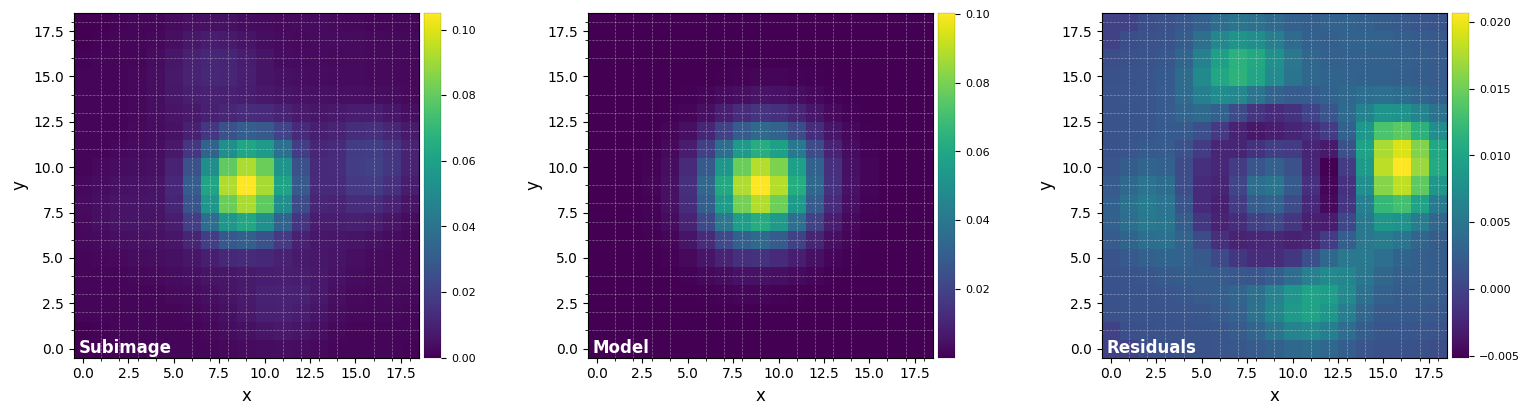

FWHM_y = 4.926059872957138
FWHM_x = 4.675778895005929 

centroid y = 9.010992107833063
centroid x = 9.01917912265807
centroid y subim = 9.010992107833063
centroid x subim = 9.01917912265807 

amplitude = 0.10032285220380603
theta = -38.446187060503874

Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307


In [4]:
%matplotlib inline
from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

In [5]:
print(fwhm_naco)

4.800919383981533


<font color=orange> **Question 3.2:** The FWHM measured above can slightly vary depending on observing conditions and quality of the adaptive optics (AO) correction. In excellent conditions, the PSF gets narrower and can approach the theoretical diffraction limit. What is that angular resolution (in arcsec and in pixels) at L' band ($\lambda \sim$ 3.8µm), for a 8.1m diameter telescope such as the VLT?</font>

---
**NOTE**

The `normalize_psf` function performs internally a fine centering of the PSF. The input PSF should nevertheless already be centered within a few pixel accuracy for the fine centering to work.

---

Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` (default) allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

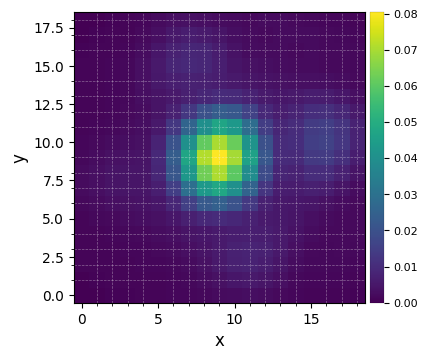

In [6]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `conf` subpackage:

In [7]:
from vip_hci.config import VLT_NACO
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


<font color=orange> **Question 3.3:** When building an instrument, one wants to make sure that even in the best observing conditions the PSF is always sampled at least at the Nyquist frequency - what would then be the coarsest pixel scale that would still allow a Nyquist sampling of the PSF at L' at the VLT? </font>

<font color=green> **Answer 3.1**: The parallactic angle depends on the celestial coordinates of the target, the latitude of the observatory and the observation time (commonly expressed in local hour angle for the target).</font> 

<font color=green> **Answer 3.2**: The theoretical diffraction limit is $\sim \lambda/D$, or $\sim$ 0.10 arcsec after conversion from radian to arcsec. This is $\sim$3.9 pixels at the NACO pixel scale. </font> 

<font color=green> **Answer 3.3**: A maximum pixel scale of 0.05 arcsec/px is required to ensure Nyquist sampling at L' band even in the best observing conditions (i.e. when $\lambda/D$ is equivalent to 2 pixels).</font> 

## 3.2. Principal Component Analysis (PCA)

### 3.2.1. PCA with data imputation

Now let's try the Principal Component Analysis (PCA)-based algorithms ([Amara & Quanz 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..948A/abstract), [Soummer et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...755L..28S/abstract)) in `vip.pca`. As a reminder, below is a schematics summarizing how full-frame PCA-ADI works: 

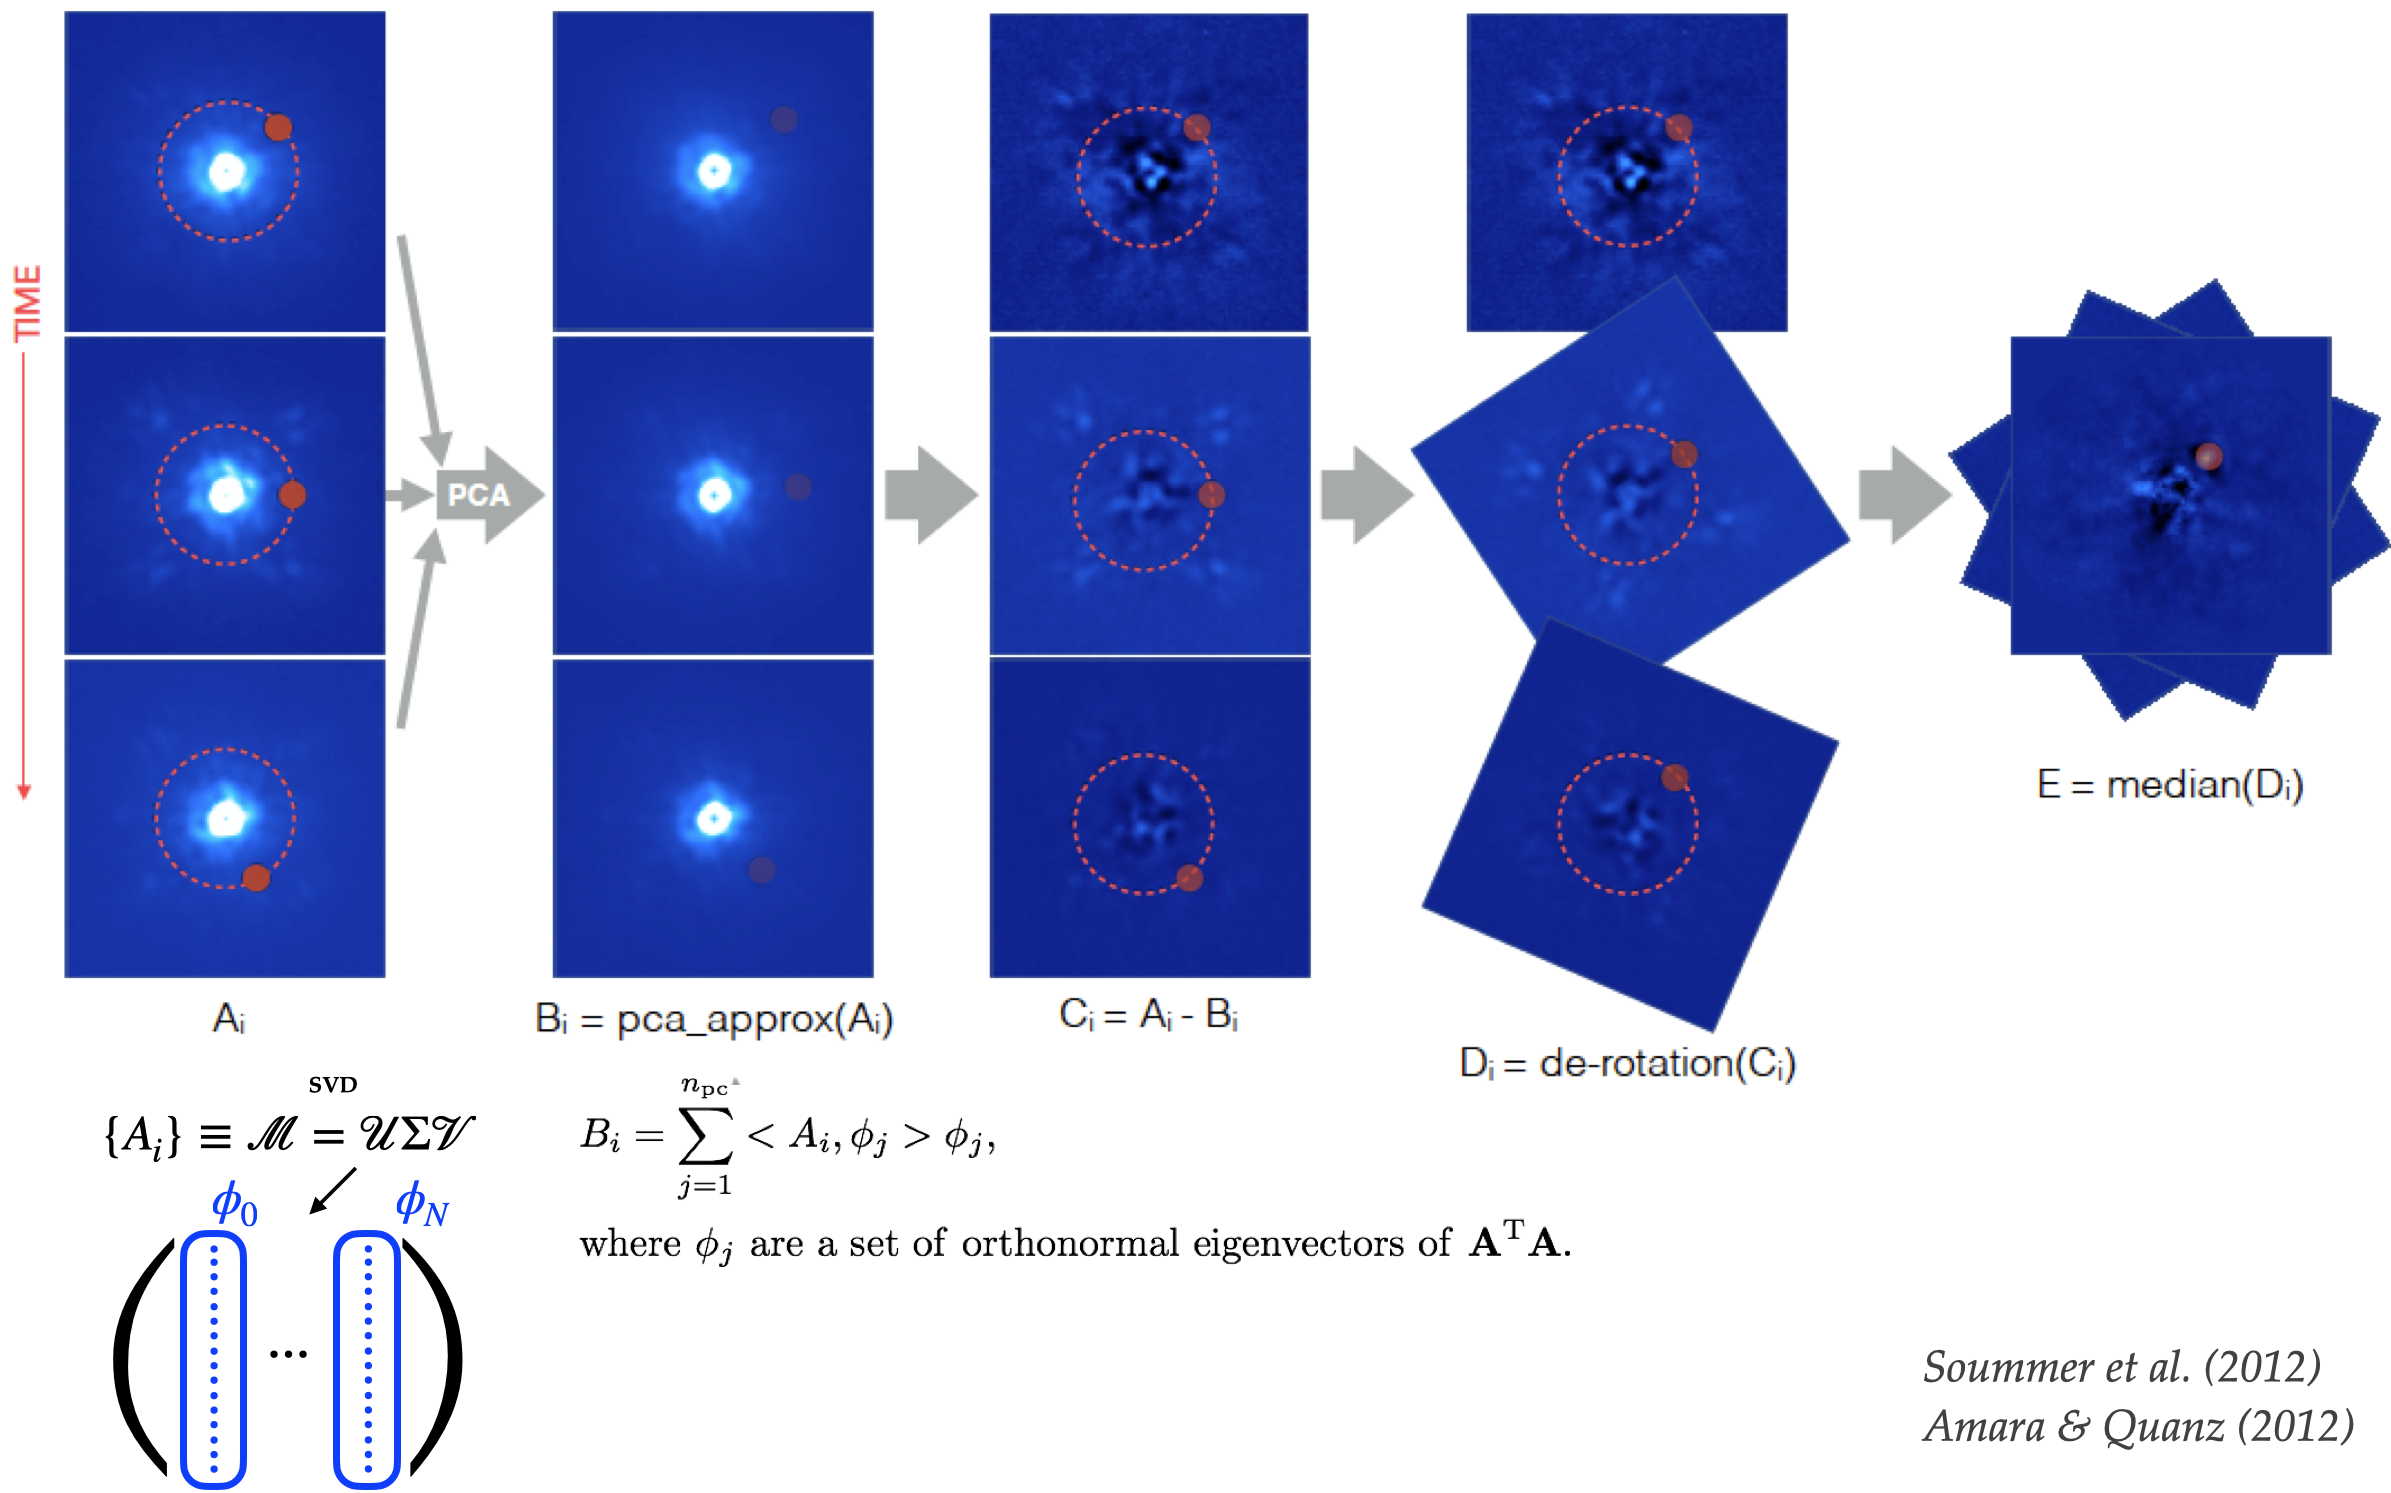

**Figure 3.2** - PCA-ADI concept. Compared to median-ADI (Fig. 3.1), only the model used for subtraction is refined. It is constructed from the projection of each image on the first $n_{\rm pc}$ principal components. The principal components are typically found by singular value decomposition, after converting the observed sequence of images $A_i$ into a 2D matrix (rows: time dimension, columns: linearized version of the images).

Let's first define a binary mask, corresponding to the area of the image which could host circumstellar signals. Let's assume it covers the inner 20px radius:

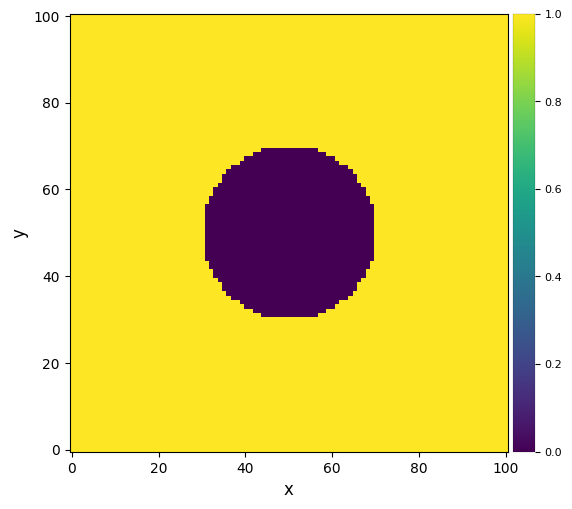

In [8]:
from vip_hci.var import mask_circle

anchor_mask = np.ones_like(cube[0])
anchor_mask = mask_circle(anchor_mask, 20)

plot_frames(anchor_mask)

Let's set to 30 the number of principal components `ncomp` considered for model creation, and let's run the PCA algorithm (feel free to test other values):

In [9]:
from vip_hci.psfsub import pca
ncomp = 30

mask_rdi1 = anchor_mask   # can be a 2D bool array

fr_pca_di1 = pca(cube, angs, ncomp=ncomp, cube_ref=cube_ref, mask_rdi=mask_rdi1, nproc=5)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-05-21 14:58:01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 2.755 GB
Done de-rotating and combining
Running time:  0:00:00.644907
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


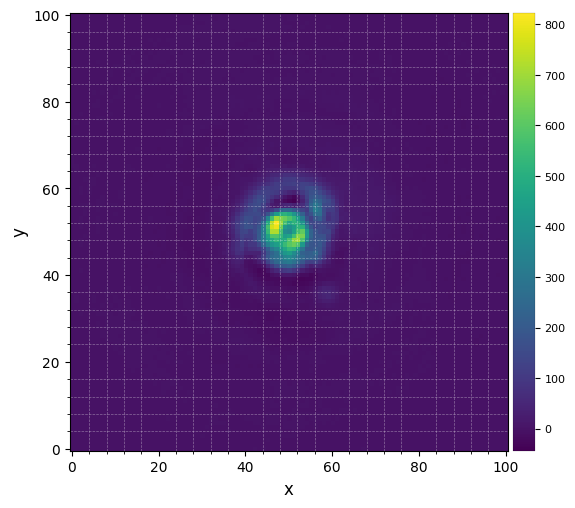

In [10]:
plot_frames(fr_pca_di1, grid=True)

There are strong residuals because the reference cube is not correlated in this example. Better practise is to define 2 masks, anchor and boat, as in [Ren et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...679A..18R/abstract).

This time let's consider more sophisticated annular masks for anchor and boat masks:

In [11]:
from vip_hci.var import get_annulus_segments
get_annulus_segments?

Signature:
get_annulus_segments(
    data,
    inner_radius,
    width,
    nsegm=1,
    theta_init=0,
    optim_scale_fact=1,
    mode='ind',
    out=False,
)
Docstring:
Return indices or values in segments of a centered annulus.

The annulus is defined by ``inner_radius <= annulus < inner_radius+width``.

Parameters
----------
data : 2d numpy ndarray or tuple
    Input 2d array (image) ot tuple with its shape.
inner_radius : float
    The inner radius of the donut region.
width : float
    The size of the annulus.
nsegm : int
    Number of segments of annulus to be extracted.
theta_init : int
    Initial azimuth [degrees] of the first segment, counting from the
    positive x-axis counterclockwise.
optim_scale_fact : float
    To enlarge the width of the segments, which can then be used as
    optimization segments (e.g. in LOCI).
mode : {'ind', 'val', 'mask'}, optional
    Controls what is returned: indices of selected pixels, values of
    selected pixels, or a boolean mask.
out : 

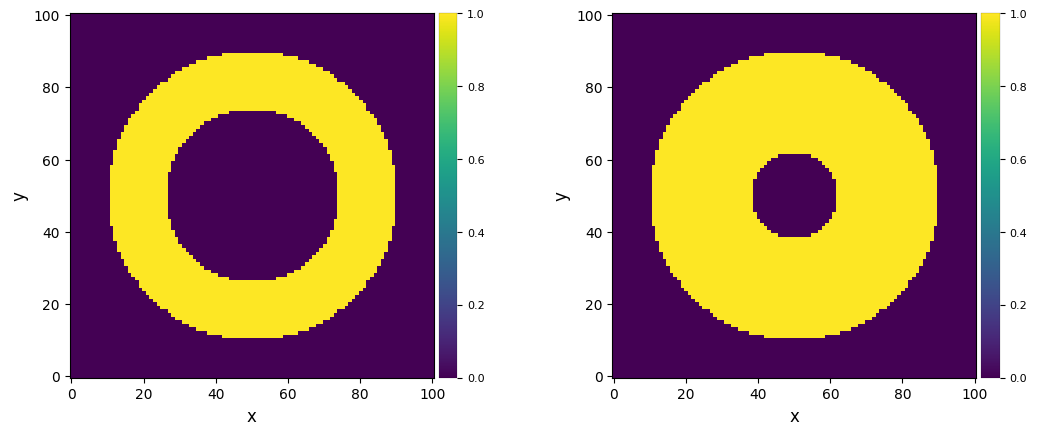

In [12]:
coro = 12    # discard signal within ~IWA of coronagraphic mask
ring_in = 24
ring_out = 40

ones = np.ones_like(cube[0])
anchor_mask = get_annulus_segments(ones, ring_in, ring_out-ring_in, mode="mask")[0]
boat_mask = get_annulus_segments(ones, coro, ring_out-coro, mode="mask")[0]

plot_frames((anchor_mask, boat_mask))

In [13]:
from vip_hci.psfsub import pca
ncomp = 30

mask_rdi2 = (anchor_mask, boat_mask)   # can be a tuple of 2 2D bool array

fr_pca_di2 = pca(cube, angs, ncomp=ncomp, cube_ref=cube_ref, mask_rdi=mask_rdi2)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-05-21 14:58:02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.114 GB
Done de-rotating and combining
Running time:  0:00:01.633811
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


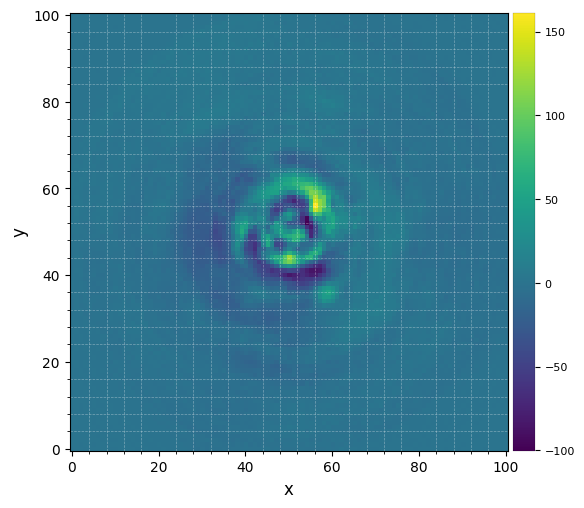

In [14]:
plot_frames(fr_pca_di2, grid=True)

### 3.2.2. Iterative PCA

**IPCA-ADI**

In [15]:
from vip_hci.greedy import ipca

fr_ipca_ADI = ipca(cube=cube, angle_list=angs, ncomp=15, nit=20)

ModuleNotFoundError: No module named 'vip_hci.greedy'

In [ ]:
%matplotlib inline
plot_frames(fr_ipca_ADI, grid=True)

To check more outputs, including the cube of images obtained at each iteration, it's a matter of setting `full_output=True`:

In [ ]:
from vip_hci.greedy import ipca

res_ipca_ADI = ipca(cube=cube, angle_list=angs, ncomp=15, nit=20, full_output=True)

In [ ]:
fr_ipca, it_cube, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ADI

In [ ]:
plot_cubes(it_cube, grid=True)

**IPCA-ARDI** (recommended)

For all cases above, and this one below, the number of PCs is constant, and the number of iterations set by `nit`.

In [51]:
from vip_hci.greedy import ipca

res_ipca_ARDI = ipca(cube=cube, angle_list=angs, ncomp=15, nit=20, cube_ref=cube_ref, strategy='ARDI', full_output=True)


Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:27


In [52]:
fr_ipca_ARDI, it_cube_ARDI, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ARDI

In [55]:
%matplotlib inline
plot_frames(fr_ipca_ARDI)

/Users/valentin/anaconda3/envs/vipenv310/lib/python3.10/site-packages/hciplot/hciplot.py:833: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 20]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
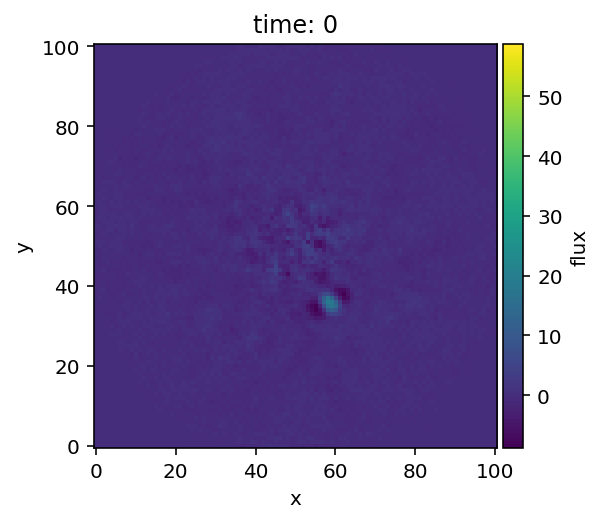

In [54]:
plot_cubes(it_cube_ARDI, grid=True)

It is possible to increase the number of PCs with the iterations by setting `mode='Pairet21'`, in this case `ncomp` is the final number of PCs at the last iteration, and `nit` is the number of iterations with each tested number of PCs:

In [66]:
from vip_hci.greedy import ipca

res_ipca_ARDI_incr = ipca(cube=cube, angle_list=angs, ncomp=30, nit=5, cube_ref=cube_ref, strategy='ARDI', 
                          mode='Pairet21', full_output=True)


Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:19:23


In [67]:
fr_ipca_ARDI_incr, it_cube_ARDI_incr, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ARDI_incr

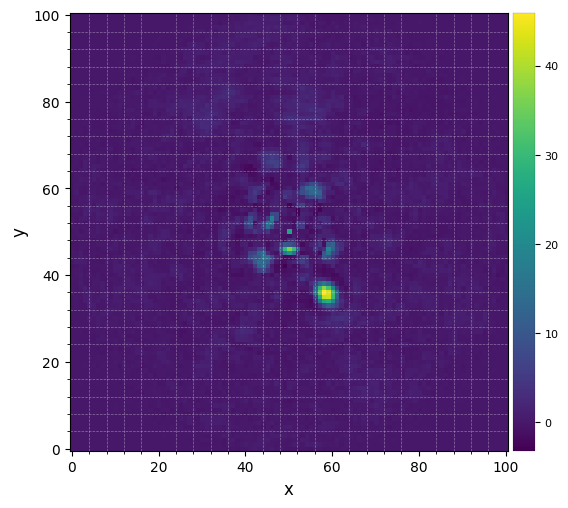

In [68]:
%matplotlib inline
plot_frames(fr_ipca_ARDI_incr, grid=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 150]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
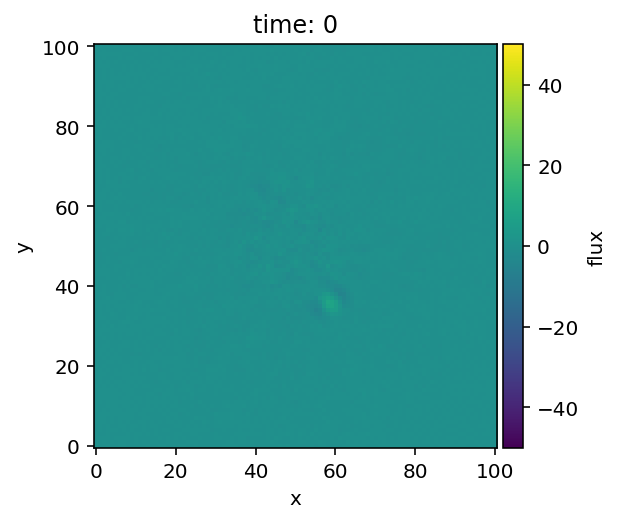

In [71]:
plot_cubes(it_cube_ARDI_incr, grid=True, vmin=-20, vmax=50)

**IPCA-ARDI** with data imputation at the first iteration (not yet much tested, but possibly even better than regular IPCA-ARDI)

In [15]:
from vip_hci.greedy import ipca

res_ipca_ARDI_di = ipca(cube=cube, angle_list=angs, ncomp=30, nit=42, cube_ref=cube_ref,
                        strategy='ARDI', mask_rdi=mask_rdi2, full_output=True)


Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:27


An internal criterion of convergence exists, and if met the algorithm can stop earlier than the requested number of iterations. The convergence criterion can be adapted with arguments `rtol` and `atol`, the relative and absolute tolerance, respectively, which concerns the difference between the images of 2 consecutive iterations.

In [18]:
fr_ipca_ARDI_di, it_cube_ARDI_di, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ARDI_di

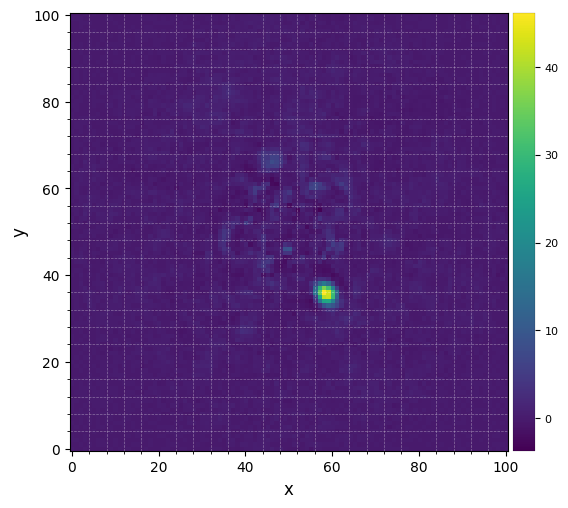

In [17]:
%matplotlib inline
plot_frames(fr_ipca_ARDI_di, grid=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 20]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
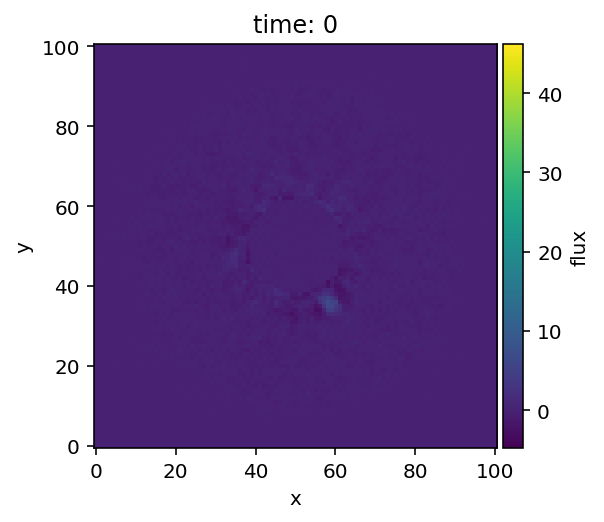

In [19]:
plot_cubes(it_cube_ARDI_di, grid=True)